## **Notebook EDA: ZARC Tábua de Risco**

Iniciando o download de: https://dados.agricultura.gov.br/dataset/6d3d141c-885e-41a4-ab7f-dc8ff323b96f/resource/a8875ff8-fe4d-4c3c-b1a1-3b19c32916f1/download/dados-abertos-tabua-de-risco.csv
Baixando e salvando em arquivo temporário: /tmp/tmprrbfsszy.csv
Download completo.
Lendo sub-amostra de 20000 linhas para inferência de dtypes e validação de formato...
Sub-amostra para dtypes lida como string com: sep=';', enc='latin1'.
Inferindo dtypes otimizados a partir da sub-amostra...
Dtypes otimizados inferidos (mapeados para nomes originais): {'ï»¿Nome_cultura': 'category', 'SafraIni': Int64Dtype(), 'SafraFin': Int64Dtype(), 'Cod_Cultura': Int64Dtype(), 'Cod_Ciclo': Int64Dtype(), 'Cod_Solo': Int64Dtype(), 'geocodigo': Int64Dtype(), 'UF': 'category', 'municipio': 'category', 'Cod_Clima': 'category', 'Nome_Clima': 'category', 'Cod_Outros_Manejos': 'category', 'Nome_Outros_Manejos': 'category', 'Produtividade': 'category', 'Cod_Munic': Int64Dtype(), 'Cod_Meso': Int64Dtype(), 'Cod_Micro': Int6

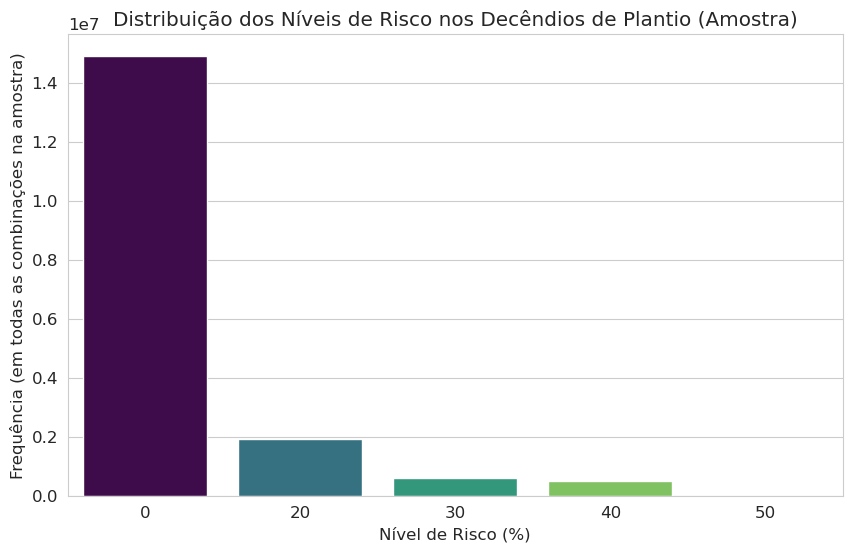

Coluna 'produtividade' tem 0 valores não nulos, insuficientes para histograma/boxplot.
Histograma e Boxplot para 'produtividade' não gerados.

Verificando colunas de texto por pistas sobre unidade de produtividade (para a coluna 'produtividade') na amostra...
A coluna 'produtividade' está 100% nula na amostra. A unidade precisará ser confirmada externamente (ex: dicionário de dados).


In [10]:
# Análise Exploratória de Dados (EDA) - ZARC Tábua de Risco (Otimizada e Corrigida)
# Objetivo: Explorar uma amostra do conjunto de dados dados-abertos-tabua-de-risco.csv
# com uso otimizado de memória, para entender sua estrutura, os níveis de risco associados
# a cada decêndio de plantio, e prepará-lo para futura integração.
# Otimizações: Inferência e aplicação detalhada de dtypes, amostragem.
# Fonte dos Dados: Ministério da Agricultura e Pecuária (MAPA)
# URL do Arquivo: https://dados.agricultura.gov.br/dataset/6d3d141c-885e-41a4-ab7f-dc8ff323b96f/resource/a8875ff8-fe4d-4c3c-b1a1-3b19c32916f1/download/dados-abertos-tabua-de-risco.csv
# NOTA: Esta análise é realizada em uma amostra para eficiência. O processamento do dataset
# completo para modelagem de longo prazo (ex: 2040) exigirá técnicas como Dask/Spark.

# 1. Configuração do Ambiente e Importação de Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
# import io
import tempfile
import os
import unicodedata # Para normalização de strings (remoção de acentos)
import re # Para expressões regulares (remoção de caracteres especiais)

# Configurações para melhor visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- Funções Auxiliares ---
def padronizar_nome_coluna(nome_coluna):
    """Padroniza um único nome de coluna."""
    if isinstance(nome_coluna, str) and nome_coluna.startswith('ï»¿'):
        nome_coluna = nome_coluna.replace('ï»¿', '')

    s = str(nome_coluna).lower()
    s = s.replace(' ', '_')
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')
    s = re.sub(r'[^a-z0-9_]', '', s)
    return s

# 2. Carregamento dos Dados via URL (Otimizado com Dtypes e Amostrado)
url_zarc_tabua_risco = 'https://dados.agricultura.gov.br/dataset/6d3d141c-885e-41a4-ab7f-dc8ff323b96f/resource/a8875ff8-fe4d-4c3c-b1a1-3b19c32916f1/download/dados-abertos-tabua-de-risco.csv'
df_tabua_risco_amostra = pd.DataFrame()
temp_file_path = None
num_linhas_amostra_eda = 500000
num_linhas_inferencia_dtype = 20000

print(f"Iniciando o download de: {url_zarc_tabua_risco}")
try:
    response = requests.get(url_zarc_tabua_risco, stream=True)
    response.raise_for_status()

    with tempfile.NamedTemporaryFile(delete=False, suffix='.csv', mode='wb') as tmp_file:
        temp_file_path = tmp_file.name
        print(f"Baixando e salvando em arquivo temporário: {temp_file_path}")
        for chunk_content in response.iter_content(chunk_size=8192):
            tmp_file.write(chunk_content)
    print("Download completo.")

    print(f"Lendo sub-amostra de {num_linhas_inferencia_dtype} linhas para inferência de dtypes e validação de formato...")
    load_attempts = [(';', 'latin1'), (',', 'latin1'), (';', 'utf-8'), (',', 'utf-8')]
    df_subset_dtype_raw = pd.DataFrame()
    best_sep = None
    best_enc = None

    for sep_attempt, enc_attempt in load_attempts:
        try:
            df_temp_dtype = pd.read_csv(temp_file_path,
                                     sep=sep_attempt,
                                     encoding=enc_attempt,
                                     low_memory=False,
                                     nrows=num_linhas_inferencia_dtype,
                                     dtype=str)
            if not df_temp_dtype.empty and len(df_temp_dtype.columns) > 1:
                print(f"Sub-amostra para dtypes lida como string com: sep='{sep_attempt}', enc='{enc_attempt}'.")
                df_subset_dtype_raw = df_temp_dtype
                best_sep = sep_attempt
                best_enc = enc_attempt
                break
            else:
                df_subset_dtype_raw = pd.DataFrame()
        except Exception as e_load_subset:
            print(f"Falha ao ler sub-amostra com sep='{sep_attempt}', enc='{enc_attempt}': {e_load_subset}")
            df_subset_dtype_raw = pd.DataFrame()
            continue

    optimized_dtypes_map_for_read = {}

    if not df_subset_dtype_raw.empty:
        original_column_names_for_read = df_subset_dtype_raw.columns.tolist()

        df_subset_for_inference = df_subset_dtype_raw.copy()
        df_subset_for_inference.columns = [padronizar_nome_coluna(col) for col in df_subset_for_inference.columns]

        print("Inferindo dtypes otimizados a partir da sub-amostra...")
        for i, col_std_name_inf in enumerate(df_subset_for_inference.columns):
            original_col_name = original_column_names_for_read[i]
            series_to_infer = df_subset_for_inference[col_std_name_inf]

            series_numeric = pd.to_numeric(series_to_infer.str.replace(',', '.', regex=False), errors='coerce')

            if not series_numeric.isnull().all():
                if not series_numeric.dropna().empty and (series_numeric.dropna() % 1 == 0).all():
                    optimized_dtypes_map_for_read[original_col_name] = pd.Int64Dtype()
                else:
                    optimized_dtypes_map_for_read[original_col_name] = 'float32'
            else:
                if series_to_infer.nunique(dropna=False) / len(series_to_infer) < 0.5 and len(series_to_infer) > series_to_infer.nunique(dropna=False) * 2 :
                    optimized_dtypes_map_for_read[original_col_name] = 'category'
                else:
                    optimized_dtypes_map_for_read[original_col_name] = 'object'

        for i, original_col_name_dec in enumerate(original_column_names_for_read):
            temp_std_name_dec_check = padronizar_nome_coluna(original_col_name_dec)
            if temp_std_name_dec_check.startswith('dec') and temp_std_name_dec_check[3:].isdigit():
                 optimized_dtypes_map_for_read[original_col_name_dec] = pd.Int64Dtype()

        print(f"Dtypes otimizados inferidos (mapeados para nomes originais): {optimized_dtypes_map_for_read}")

        print(f"Lendo amostra principal de {num_linhas_amostra_eda} linhas com dtypes otimizados...")
        df_tabua_risco_amostra = pd.read_csv(temp_file_path,
                                     sep=best_sep,
                                     encoding=best_enc,
                                     low_memory=False,
                                     nrows=num_linhas_amostra_eda,
                                     dtype=optimized_dtypes_map_for_read)
        if not df_tabua_risco_amostra.empty:
            print(f"Amostra principal de {len(df_tabua_risco_amostra)} linhas lida com sucesso.")
        else:
            print("Falha ao ler amostra principal com dtypes otimizados. Tentando ler como string...")
            df_tabua_risco_amostra = pd.read_csv(temp_file_path, sep=best_sep, encoding=best_enc, low_memory=False, nrows=num_linhas_amostra_eda, dtype=str)
            if not df_tabua_risco_amostra.empty:
                 print(f"Amostra principal lida como string. {len(df_tabua_risco_amostra)} linhas.")
            else:
                 print("Falha total ao ler amostra principal.")
    else:
        print("Não foi possível ler a sub-amostra para inferência de dtypes.")

except requests.exceptions.RequestException as e_http:
    print(f"Erro na requisição HTTP: {e_http}")
except Exception as e_geral:
    print(f"Um erro geral ocorreu durante o download ou leitura inicial: {e_geral}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        try:
            os.remove(temp_file_path)
            print(f"Arquivo temporário {temp_file_path} removido.")
        except Exception as e_remove:
            print(f"Erro ao remover arquivo temporário {temp_file_path}: {e_remove}")

# 3. Inspeção Inicial dos Dados da Amostra
if not df_tabua_risco_amostra.empty:
    print("\nPrimeiras 5 linhas do DataFrame (Amostra Otimizada ZARC Tábua de Risco):")
    print(df_tabua_risco_amostra.head())
    print(f"\nDimensões do DataFrame da Amostra (Linhas, Colunas): {df_tabua_risco_amostra.shape}")
    print("\nInformações sobre o DataFrame da Amostra (com dtypes otimizados):")
    df_tabua_risco_amostra.info(memory_usage='deep')
else:
    print("\nDataFrame ZARC Tábua de Risco (Amostra) está vazio.")

# 4. Padronização de Nomes de Colunas (Aplicada na amostra carregada)
colunas_decendios_padronizadas = []
if not df_tabua_risco_amostra.empty:
    print("\nNomes das colunas antes da padronização final:", df_tabua_risco_amostra.columns.tolist())

    df_tabua_risco_amostra.columns = [padronizar_nome_coluna(col) for col in df_tabua_risco_amostra.columns]
    print("Nomes das colunas padronizados final:", df_tabua_risco_amostra.columns.tolist())

    colunas_decendios_padronizadas = [col for col in df_tabua_risco_amostra.columns if col.startswith('dec') and col[3:].isdigit()]
    print(f"Colunas de decêndios identificadas após padronização final: {colunas_decendios_padronizadas}")
    print(df_tabua_risco_amostra.head(2))

# 5. Conversão de Tipos Adicional (se necessário) e Análise Descritiva
if not df_tabua_risco_amostra.empty:
    print("\nVerificando e aplicando dtypes pós-leitura (se necessário)...")

    for col_dec in colunas_decendios_padronizadas:
        if col_dec in df_tabua_risco_amostra.columns:
            if not isinstance(df_tabua_risco_amostra[col_dec].dtype, pd.Int64Dtype) and not pd.api.types.is_integer_dtype(df_tabua_risco_amostra[col_dec].dtype): # Checa se já não é Int64 ou outro int
                print(f"Convertendo coluna de decêndio '{col_dec}' para Int64Dtype.")
                df_tabua_risco_amostra[col_dec] = pd.to_numeric(df_tabua_risco_amostra[col_dec], errors='coerce').astype(pd.Int64Dtype())

    coluna_produtividade_nome_padronizado = 'produtividade'
    if coluna_produtividade_nome_padronizado in df_tabua_risco_amostra.columns:
        print(f"\nAnalisando a coluna '{coluna_produtividade_nome_padronizado}':")
        if not pd.api.types.is_numeric_dtype(df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].dtype):
            print(f"Tentando converter coluna '{coluna_produtividade_nome_padronizado}' (dtype: {df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].dtype}) para float32.")
            try:
                df_tabua_risco_amostra[coluna_produtividade_nome_padronizado] = pd.to_numeric(
                    df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].astype(str).str.replace(',', '.', regex=False),
                    errors='coerce'
                ).astype('float32')
            except Exception as e_conv_prod:
                print(f"Erro ao converter '{coluna_produtividade_nome_padronizado}' para float32: {e_conv_prod}")

        print(f"Estatísticas descritivas para '{coluna_produtividade_nome_padronizado}':")
        print(df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].describe())
        print(f"Valores ausentes em '{coluna_produtividade_nome_padronizado}': {df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].isnull().sum()} ({df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].isnull().mean()*100:.2f}%)")
    else:
        print(f"\nColuna '{coluna_produtividade_nome_padronizado}' não encontrada após padronização.")

    print("\nContagem de valores únicos para colunas categóricas chave (Top 10):")
    coluna_cultura_nome_final_desc = 'nome_cultura' # Nome esperado após padronização

    colunas_categoricas_tabua_exemplo = [coluna_cultura_nome_final_desc, 'uf', 'municipio', 'safrafin', 'portaria', 'cod_solo', 'cod_ciclo']

    for col in colunas_categoricas_tabua_exemplo:
        if col in df_tabua_risco_amostra.columns:
            print(f"\nValores únicos e contagem para a coluna '{col}':")
            print(df_tabua_risco_amostra[col].value_counts(dropna=False).nlargest(10))
        else:
            print(f"\nColuna categórica de exemplo '{col}' não encontrada. Colunas disponíveis: {df_tabua_risco_amostra.columns.tolist()}")
else:
    print("DataFrame ZARC Tábua de Risco (Amostra) está vazio. Análise descritiva não realizada.")

# 6. Verificação de Valores Ausentes (Missing Values) - Geral
if not df_tabua_risco_amostra.empty:
    print("\nResumo de Valores Ausentes (Amostra ZARC Tábua de Risco):")
    missing_info_tabua_geral = df_tabua_risco_amostra.isnull().sum()
    missing_info_tabua_geral = missing_info_tabua_geral[missing_info_tabua_geral > 0].sort_values(ascending=False)
    if not missing_info_tabua_geral.empty:
        print(pd.DataFrame({'Contagem_Ausentes': missing_info_tabua_geral,
                            'Porcentagem_Ausentes_percent': (missing_info_tabua_geral / len(df_tabua_risco_amostra)) * 100}))
    else:
        print("Nenhum valor ausente encontrado na Amostra.")
else:
    print("DataFrame ZARC Tábua de Risco (Amostra) está vazio.")

# 7. Visualizações Iniciais - Foco nos Níveis de Risco dos Decêndios (na Amostra)
if not df_tabua_risco_amostra.empty and colunas_decendios_padronizadas:
    dec_data_list_viz = []
    for col_dec_viz in colunas_decendios_padronizadas:
        if col_dec_viz in df_tabua_risco_amostra.columns and pd.api.types.is_numeric_dtype(df_tabua_risco_amostra[col_dec_viz].dtype):
            dec_data_list_viz.append(df_tabua_risco_amostra[col_dec_viz].dropna())

    if dec_data_list_viz:
        valores_risco_decendios_viz = pd.concat(dec_data_list_viz, ignore_index=True)
        if not valores_risco_decendios_viz.empty:
            plt.figure(figsize=(10, 6))
            plot_data_risco = valores_risco_decendios_viz.astype(pd.Int64Dtype())

            # Corrigindo o aviso de depreciação do Seaborn: especificar 'x' e opcionalmente 'hue'
            # Se quisermos que as cores variem por 'risco', usamos 'hue'. Se não, removemos 'palette'.
            sns.countplot(data=pd.DataFrame({ 'risco_decendio': plot_data_risco }),
                          x='risco_decendio',
                          hue='risco_decendio', # Para ter cores diferentes por barra, como antes com 'palette'
                          palette='viridis',
                          order=sorted(plot_data_risco.unique()),
                          legend=False) # Remove a legenda de 'hue' se não for necessária

            plt.title('Distribuição dos Níveis de Risco nos Decêndios de Plantio (Amostra)')
            plt.xlabel('Nível de Risco (%)')
            plt.ylabel('Frequência (em todas as combinações na amostra)')
            plt.show()
        else:
            print("Não há dados válidos de risco nos decêndios para plotar na amostra após concatenação.")
    else:
        print("Nenhuma coluna de decêndio numérica encontrada para visualização.")

    # Visualização da coluna 'produtividade'
    if coluna_produtividade_nome_padronizado in df_tabua_risco_amostra.columns and \
       pd.api.types.is_numeric_dtype(df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].dtype) and \
       df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].notna().sum() > 10: # Pelo menos alguns dados para plotar

        plt.figure(figsize=(12, 6))
        sns.histplot(df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].dropna(), kde=True, bins=50)
        plt.title(f'Distribuição da Coluna "{coluna_produtividade_nome_padronizado}" (Amostra - Não Nulos)')
        plt.xlabel('Valor da Produtividade (unidade a ser confirmada)')
        plt.ylabel('Frequência')
        plt.show()

        coluna_cultura_nome_final_viz = 'nome_cultura' # Nome esperado após padronização

        if coluna_cultura_nome_final_viz in df_tabua_risco_amostra.columns:
            # Garantir que a coluna de cultura seja do tipo 'category' ou 'object' para value_counts
            if not (pd.api.types.is_categorical_dtype(df_tabua_risco_amostra[coluna_cultura_nome_final_viz].dtype) or \
                    df_tabua_risco_amostra[coluna_cultura_nome_final_viz].dtype == 'object'):
                df_tabua_risco_amostra[coluna_cultura_nome_final_viz] = df_tabua_risco_amostra[coluna_cultura_nome_final_viz].astype(str)


            top_culturas_prod_amostra = df_tabua_risco_amostra[coluna_cultura_nome_final_viz].value_counts().nlargest(5).index
            df_top_culturas_prod_amostra = df_tabua_risco_amostra[df_tabua_risco_amostra[coluna_cultura_nome_final_viz].isin(top_culturas_prod_amostra)]

            # Filtrar NaNs na coluna de produtividade antes do boxplot
            df_plot_boxplot_amostra = df_top_culturas_prod_amostra.dropna(subset=[coluna_produtividade_nome_padronizado])

            if not df_plot_boxplot_amostra.empty:
                plt.figure(figsize=(14, 7))
                sns.boxplot(data=df_plot_boxplot_amostra, x=coluna_cultura_nome_final_viz, y=coluna_produtividade_nome_padronizado, palette='pastel')
                plt.title(f'Coluna "{coluna_produtividade_nome_padronizado}" por Cultura (Amostra - Top 5)')
                plt.xlabel('Cultura')
                plt.ylabel('Valor da Produtividade')
                plt.xticks(rotation=15, ha='right')
                plt.tight_layout()
                plt.show()
            else:
                print(f"Não há dados de produtividade válidos para as top 5 culturas na amostra para o boxplot da coluna '{coluna_produtividade_nome_padronizado}'.")
        else:
            print(f"Coluna de cultura ('{coluna_cultura_nome_final_viz}') não encontrada para boxplot de produtividade na amostra.")
    else:
        # Mensagem mais detalhada se a coluna 'produtividade' não puder ser plotada
        if coluna_produtividade_nome_padronizado not in df_tabua_risco_amostra.columns:
            print(f"Coluna '{coluna_produtividade_nome_padronizado}' não encontrada.")
        elif not pd.api.types.is_numeric_dtype(df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].dtype):
            print(f"Coluna '{coluna_produtividade_nome_padronizado}' não é numérica (dtype: {df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].dtype}).")
        elif df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].notna().sum() <= 10:
            print(f"Coluna '{coluna_produtividade_nome_padronizado}' tem {df_tabua_risco_amostra[coluna_produtividade_nome_padronizado].notna().sum()} valores não nulos, insuficientes para histograma/boxplot.")
        print(f"Histograma e Boxplot para '{coluna_produtividade_nome_padronizado}' não gerados.")

else:
    if df_tabua_risco_amostra.empty:
        print("DataFrame ZARC Tábua de Risco (Amostra) está vazio. Visualizações não podem ser geradas.")
    else:
        print("Colunas de decêndios não foram identificadas no DataFrame da amostra ou não contêm dados numéricos. Visualizações de risco não podem ser geradas.")

# 8. Verificação da Unidade de Produtividade (para a coluna 'produtividade' na Amostra)
if not df_tabua_risco_amostra.empty:
    print("\nVerificando colunas de texto por pistas sobre unidade de produtividade (para a coluna 'produtividade') na amostra...")
    # A coluna 'Produtividade' está 100% nula na amostra, então não podemos inferir a unidade a partir dela.
    print("A coluna 'produtividade' está 100% nula na amostra. A unidade precisará ser confirmada externamente (ex: dicionário de dados).")
else:
    print("DataFrame ZARC Tábua de Risco (Amostra) está vazio.")

# 9. Considerações para Modelagem Futura e Processamento do Dataset Completo (Rumo a 2040)
# (Mantido como no anterior)

# 10. Próximos Passos Imediatos (EDA)
# - Limpeza de Dados mais aprofundada na amostra.
# - Investigar por que a coluna 'produtividade' está 100% nula na amostra de 500k linhas.
#   Pode ser necessário verificar uma amostra maior ou o arquivo completo (com cuidado) para ver se há dados.
# - Se a EDA na amostra for promissora, considerar estratégias para processar o arquivo completo em chunks
#   para análises agregadas específicas ou usar Dask/Modin.
# - Preparar para integração com a amostra do df_zarc_cronograma.

## **Notebook EDA: SIGEF Campos de Sementes**

Iniciando o download de: https://dados.agricultura.gov.br/dataset/c7784a6e-f0ec-4196-a1ce-1d2d4784a58e/resource/3fc8e266-ec41-40b0-8d62-157b91b36b2c/download/sigefdeclaracaoareaproducao.csv
Baixando e salvando em arquivo temporário: /tmp/tmpl1dj11w9.csv
Download completo.
Lendo sub-amostra de 20000 linhas para inferência de dtypes e validação de formato...
Sub-amostra para dtypes (SIGEF Declaração) lida como string com: sep=';', enc='latin1'.
Inferindo dtypes otimizados a partir da sub-amostra (SIGEF Declaração)...
Dtypes otimizados inferidos (SIGEF Declaração): {'TIPOPERIODO': 'category', 'PERIODO': 'category', 'AREATOTAL': 'float32', 'MUNICIPIO': 'category', 'UF': 'category', 'ESPECIE': 'category', 'CULTIVAR': 'category', 'AREAPLANTADA': 'float32', 'AREAESTIMADA': 'float32', 'QUANTRESERVADA': 'float32', 'DATAPLANTIO': 'object'}
Lendo amostra principal de 500000 linhas (SIGEF Declaração) com dtypes otimizados...
Amostra principal (SIGEF Declaração) de 225106 linhas lida com sucesso.
A

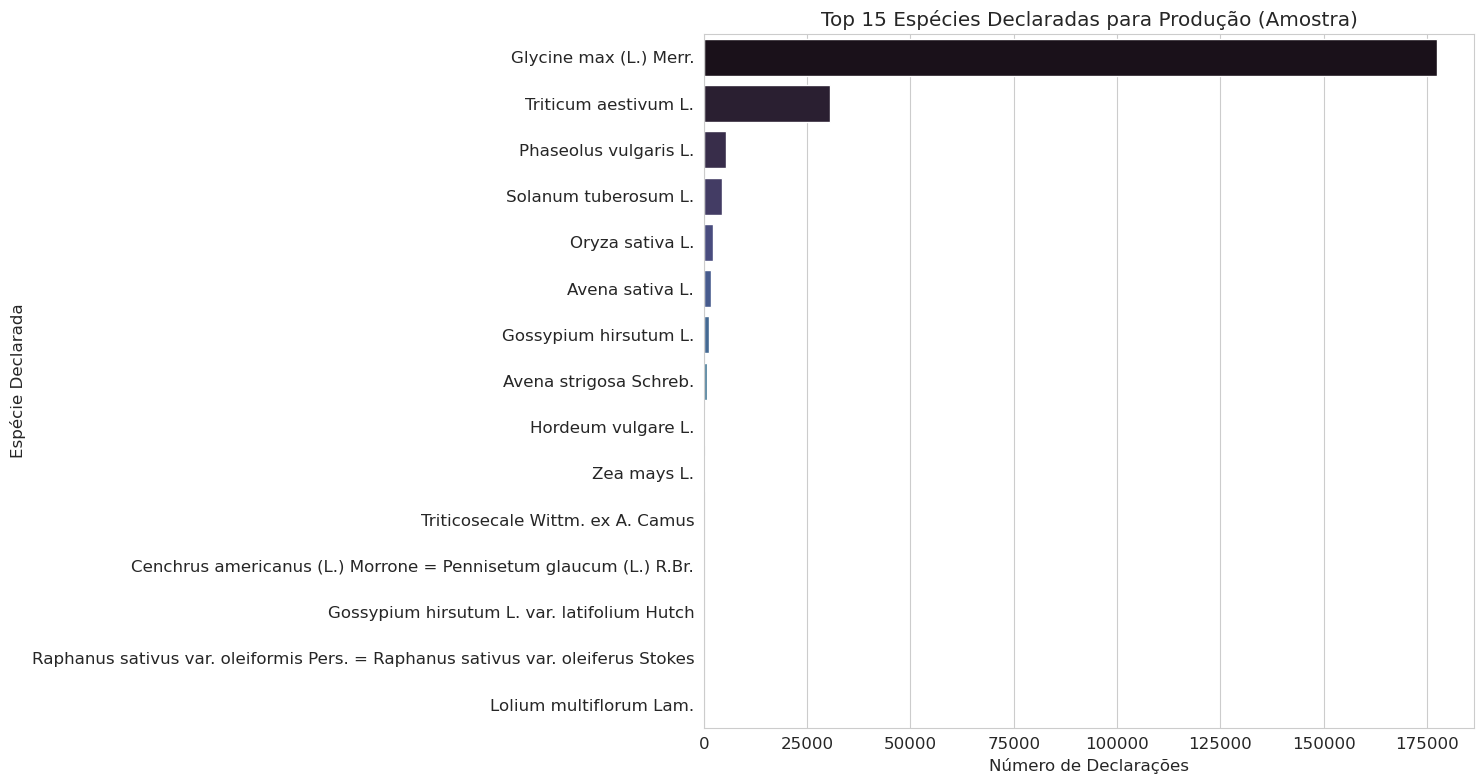

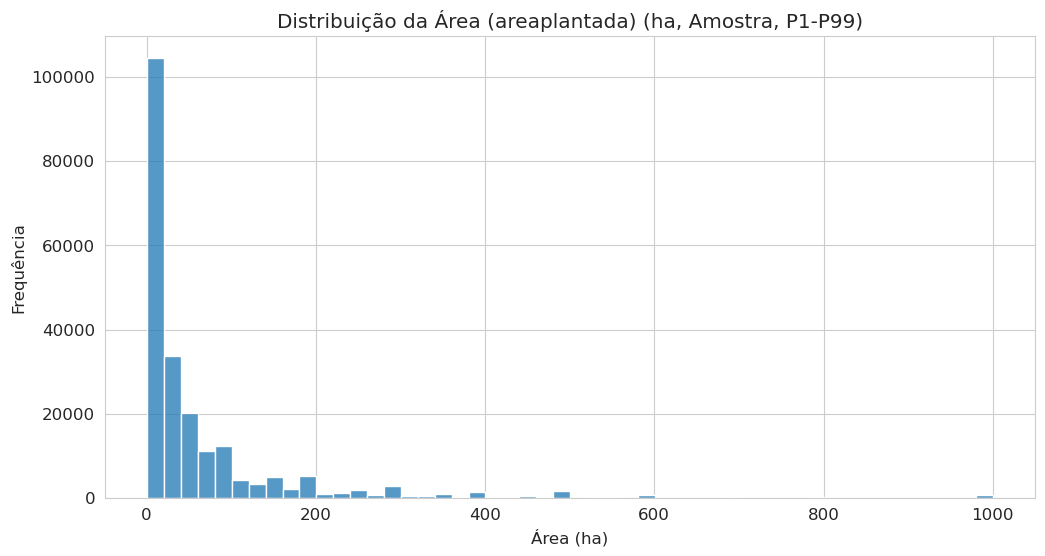

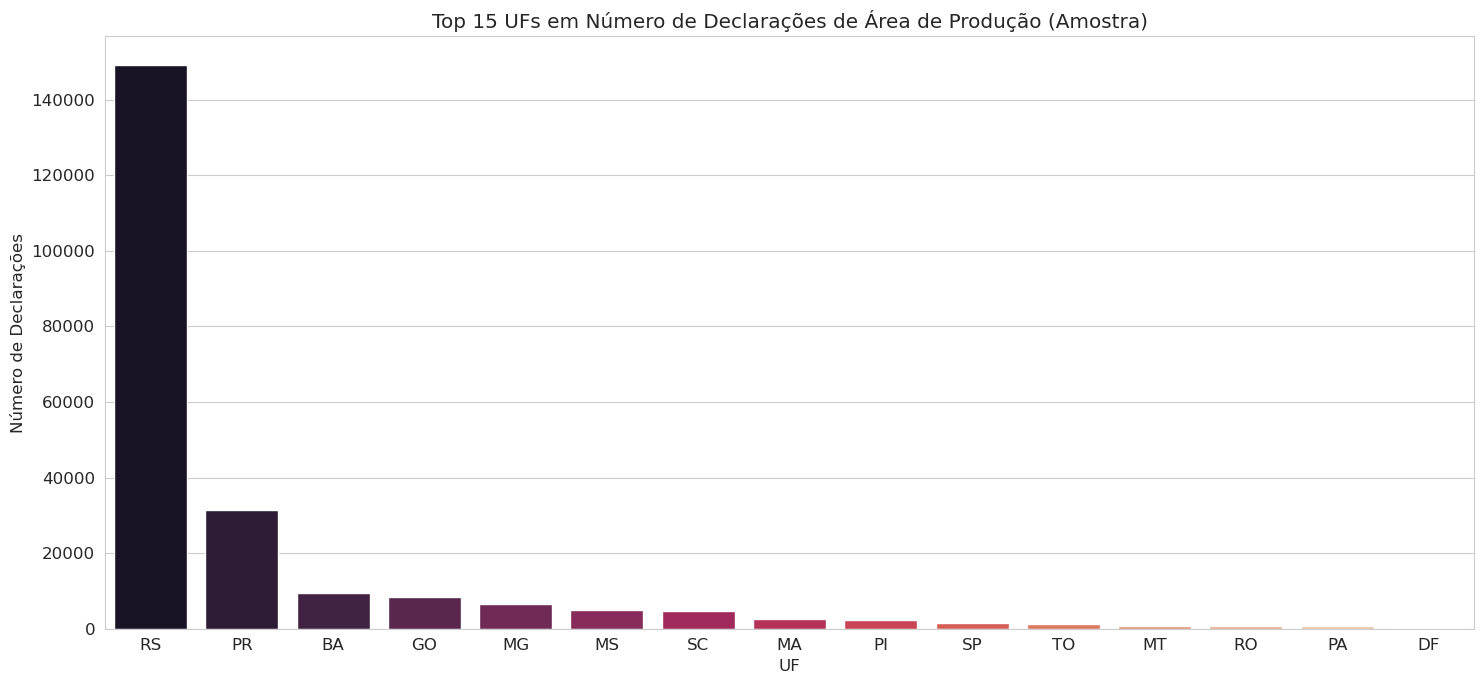

In [11]:
# Análise Exploratória de Dados (EDA) - SIGEF Declaração de Área de Produção (Otimizada e Corrigida)
# Objetivo: Explorar uma amostra do conjunto de dados sigefdeclaracaoareaproducao.csv
# com uso otimizado de memória, para entender sua estrutura, as culturas e áreas declaradas,
# e prepará-lo para futura integração com os dados ZARC e SIGEF Sementes.
# Otimizações: Inferência e aplicação detalhada de dtypes, amostragem.
# Fonte dos Dados: Ministério da Agricultura e Pecuária (MAPA) - SIGEF
# URL do Arquivo: https://dados.agricultura.gov.br/dataset/c7784a6e-f0ec-4196-a1ce-1d2d4784a58e/resource/3fc8e266-ec41-40b0-8d62-157b91b36b2c/download/sigefdeclaracaoareaproducao.csv
# NOTA: Esta análise é realizada em uma amostra para eficiência. O processamento do dataset
# completo para modelagem de longo prazo exigirá técnicas como Dask/Spark.

# 1. Configuração do Ambiente e Importação de Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import tempfile
import os
import unicodedata
import re

# Configurações para melhor visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# --- Funções Auxiliares ---
def padronizar_nome_coluna(nome_coluna):
    """Padroniza um único nome de coluna."""
    if isinstance(nome_coluna, str) and nome_coluna.startswith('ï»¿'):
        nome_coluna = nome_coluna.replace('ï»¿', '')

    s = str(nome_coluna).lower()
    s = s.replace(' ', '_')
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')
    s = re.sub(r'[^a-z0-9_]', '', s)
    return s

def otimizar_dtypes_numericos(df, p_colunas_numericas):
    """Otimiza os tipos de dados de colunas numéricas para economizar memória."""
    df_copy = df.copy()
    for col in p_colunas_numericas:
        if col not in df_copy.columns:
            continue

        if pd.api.types.is_string_dtype(df_copy[col]) or df_copy[col].dtype == 'object' or isinstance(df_copy[col].dtype, pd.CategoricalDtype):
            df_copy[col] = pd.to_numeric(df_copy[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')
        elif not pd.api.types.is_numeric_dtype(df_copy[col]):
             df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

        if df_copy[col].isnull().all():
            continue

        if not df_copy[col].dropna().empty and (df_copy[col].dropna() % 1 == 0).all():
            max_val = df_copy[col].max()
            min_val = df_copy[col].min()
            if pd.isna(max_val) or pd.isna(min_val):
                 df_copy[col] = df_copy[col].astype(pd.Int64Dtype())
                 continue
            if min_val >= 0:
                if max_val < 2**8: df_copy[col] = df_copy[col].astype('UInt8')
                elif max_val < 2**16: df_copy[col] = df_copy[col].astype('UInt16')
                elif max_val < 2**32: df_copy[col] = df_copy[col].astype('UInt32')
                else: df_copy[col] = df_copy[col].astype('UInt64')
            else:
                if min_val >= -2**7 and max_val < 2**7: df_copy[col] = df_copy[col].astype('Int8')
                elif min_val >= -2**15 and max_val < 2**15: df_copy[col] = df_copy[col].astype('Int16')
                elif min_val >= -2**31 and max_val < 2**31: df_copy[col] = df_copy[col].astype('Int32')
                else: df_copy[col] = df_copy[col].astype('Int64')
        elif pd.api.types.is_float_dtype(df_copy[col].dtype):
            df_copy[col] = df_copy[col].astype('float32')
        elif pd.api.types.is_integer_dtype(df_copy[col].dtype) or isinstance(df_copy[col].dtype, pd.Int64Dtype):
            pass
    return df_copy

def otimizar_dtypes_categoricos(df, p_colunas_categoricas):
    """Converte colunas de string com baixa cardinalidade para o tipo 'category'."""
    df_copy = df.copy()
    for col in p_colunas_categoricas:
        if col not in df_copy.columns:
            continue
        if (df_copy[col].dtype == 'object' or pd.api.types.is_string_dtype(df_copy[col].dtype)) and \
           not isinstance(df_copy[col].dtype, pd.CategoricalDtype):
            num_unique_values = df_copy[col].nunique()
            num_total_values = len(df_copy[col])
            if num_unique_values / num_total_values < 0.5 and num_unique_values < 20000 :
                try:
                    df_copy[col] = df_copy[col].astype('category')
                except Exception as e_cat:
                    print(f"Não foi possível converter a coluna '{col}' para category: {e_cat}")
    return df_copy

# 2. Carregamento dos Dados via URL (Otimizado com Dtypes e Amostrado)
url_sigef_declaracao = 'https://dados.agricultura.gov.br/dataset/c7784a6e-f0ec-4196-a1ce-1d2d4784a58e/resource/3fc8e266-ec41-40b0-8d62-157b91b36b2c/download/sigefdeclaracaoareaproducao.csv'
df_sigef_declaracao_amostra = pd.DataFrame()
temp_file_path_declaracao = None
num_linhas_amostra_eda_declaracao = 500000
num_linhas_inferencia_dtype_declaracao = 20000

print(f"Iniciando o download de: {url_sigef_declaracao}")
try:
    response_declaracao = requests.get(url_sigef_declaracao, stream=True)
    response_declaracao.raise_for_status()

    with tempfile.NamedTemporaryFile(delete=False, suffix='.csv', mode='wb') as tmp_file_declaracao:
        temp_file_path_declaracao = tmp_file_declaracao.name
        print(f"Baixando e salvando em arquivo temporário: {temp_file_path_declaracao}")
        for chunk_content_declaracao in response_declaracao.iter_content(chunk_size=8192):
            tmp_file_declaracao.write(chunk_content_declaracao)
    print("Download completo.")

    print(f"Lendo sub-amostra de {num_linhas_inferencia_dtype_declaracao} linhas para inferência de dtypes e validação de formato...")
    load_attempts_declaracao = [(';', 'latin1'), (',', 'latin1'), (';', 'utf-8'), (',', 'utf-8')]
    df_subset_dtype_raw_declaracao = pd.DataFrame()
    best_sep_declaracao = None
    best_enc_declaracao = None

    for sep_attempt, enc_attempt in load_attempts_declaracao:
        try:
            df_temp_dtype_declaracao = pd.read_csv(temp_file_path_declaracao,
                                     sep=sep_attempt,
                                     encoding=enc_attempt,
                                     low_memory=False,
                                     nrows=num_linhas_inferencia_dtype_declaracao,
                                     dtype=str)
            if not df_temp_dtype_declaracao.empty and len(df_temp_dtype_declaracao.columns) > 1:
                print(f"Sub-amostra para dtypes (SIGEF Declaração) lida como string com: sep='{sep_attempt}', enc='{enc_attempt}'.")
                df_subset_dtype_raw_declaracao = df_temp_dtype_declaracao
                best_sep_declaracao = sep_attempt
                best_enc_declaracao = enc_attempt
                break
            else:
                df_subset_dtype_raw_declaracao = pd.DataFrame()
        except Exception as e_load_subset_declaracao:
            print(f"Falha ao ler sub-amostra (SIGEF Declaração) com sep='{sep_attempt}', enc='{enc_attempt}': {e_load_subset_declaracao}")
            df_subset_dtype_raw_declaracao = pd.DataFrame()
            continue

    optimized_dtypes_map_for_read_declaracao = {}

    if not df_subset_dtype_raw_declaracao.empty:
        original_column_names_for_read_declaracao = df_subset_dtype_raw_declaracao.columns.tolist()

        df_subset_for_inference_declaracao = df_subset_dtype_raw_declaracao.copy()
        df_subset_for_inference_declaracao.columns = [padronizar_nome_coluna(col) for col in df_subset_for_inference_declaracao.columns]

        print("Inferindo dtypes otimizados a partir da sub-amostra (SIGEF Declaração)...")
        for i, col_std_name_inf_declaracao in enumerate(df_subset_for_inference_declaracao.columns):
            original_col_name_declaracao = original_column_names_for_read_declaracao[i]
            series_to_infer_declaracao = df_subset_for_inference_declaracao[col_std_name_inf_declaracao]

            if col_std_name_inf_declaracao == 'dataplantio':
                optimized_dtypes_map_for_read_declaracao[original_col_name_declaracao] = 'object'
                # print(f"Coluna '{original_col_name_declaracao}' (padronizado: {col_std_name_inf_declaracao}) marcada como 'object' para conversão de data posterior.")
                continue

            series_numeric_declaracao = pd.to_numeric(series_to_infer_declaracao.str.replace(',', '.', regex=False), errors='coerce')

            if not series_numeric_declaracao.isnull().all():
                if not series_numeric_declaracao.dropna().empty and (series_numeric_declaracao.dropna() % 1 == 0).all():
                    optimized_dtypes_map_for_read_declaracao[original_col_name_declaracao] = pd.Int64Dtype()
                else:
                    optimized_dtypes_map_for_read_declaracao[original_col_name_declaracao] = 'float32'
            else:
                if series_to_infer_declaracao.nunique(dropna=False) / len(series_to_infer_declaracao) < 0.5 and series_to_infer_declaracao.nunique(dropna=False) < 20000 :
                    optimized_dtypes_map_for_read_declaracao[original_col_name_declaracao] = 'category'
                else:
                    optimized_dtypes_map_for_read_declaracao[original_col_name_declaracao] = 'object'

        print(f"Dtypes otimizados inferidos (SIGEF Declaração): {optimized_dtypes_map_for_read_declaracao}")

        print(f"Lendo amostra principal de {num_linhas_amostra_eda_declaracao} linhas (SIGEF Declaração) com dtypes otimizados...")
        df_sigef_declaracao_amostra = pd.read_csv(temp_file_path_declaracao,
                                     sep=best_sep_declaracao,
                                     encoding=best_enc_declaracao,
                                     low_memory=False,
                                     nrows=num_linhas_amostra_eda_declaracao,
                                     dtype=optimized_dtypes_map_for_read_declaracao)
        if not df_sigef_declaracao_amostra.empty:
            print(f"Amostra principal (SIGEF Declaração) de {len(df_sigef_declaracao_amostra)} linhas lida com sucesso.")
        else:
            print("Falha ao ler amostra principal (SIGEF Declaração) com dtypes otimizados. Tentando ler como string...")
            df_sigef_declaracao_amostra = pd.read_csv(temp_file_path_declaracao, sep=best_sep_declaracao, encoding=best_enc_declaracao, low_memory=False, nrows=num_linhas_amostra_eda_declaracao, dtype=str)
            if not df_sigef_declaracao_amostra.empty:
                 print(f"Amostra principal (SIGEF Declaração) lida como string. {len(df_sigef_declaracao_amostra)} linhas.")
            else:
                 print("Falha total ao ler amostra principal (SIGEF Declaração).")
    else:
        print("Não foi possível ler a sub-amostra (SIGEF Declaração) para inferência de dtypes.")

except requests.exceptions.RequestException as e_http_declaracao:
    print(f"Erro na requisição HTTP (SIGEF Declaração): {e_http_declaracao}")
except Exception as e_geral_declaracao:
    print(f"Um erro geral ocorreu durante o download ou leitura inicial (SIGEF Declaração): {e_geral_declaracao}")
finally:
    if temp_file_path_declaracao and os.path.exists(temp_file_path_declaracao):
        try:
            os.remove(temp_file_path_declaracao)
            print(f"Arquivo temporário {temp_file_path_declaracao} removido.")
        except Exception as e_remove_declaracao:
            print(f"Erro ao remover arquivo temporário {temp_file_path_declaracao}: {e_remove_declaracao}")

# 3. Inspeção Inicial dos Dados da Amostra
if not df_sigef_declaracao_amostra.empty:
    print("\nPrimeiras 5 linhas do DataFrame (Amostra SIGEF Declaração de Área):")
    print(df_sigef_declaracao_amostra.head())
    print(f"\nDimensões do DataFrame da Amostra (Linhas, Colunas): {df_sigef_declaracao_amostra.shape}")
    print("\nInformações sobre o DataFrame da Amostra (SIGEF Declaração):")
    df_sigef_declaracao_amostra.info(memory_usage='deep')
else:
    print("\nDataFrame SIGEF Declaração de Área (Amostra) está vazio.")

# 4. Padronização de Nomes de Colunas
if not df_sigef_declaracao_amostra.empty:
    print("\nNomes das colunas antes da padronização (SIGEF Declaração):", df_sigef_declaracao_amostra.columns.tolist())
    df_sigef_declaracao_amostra.columns = [padronizar_nome_coluna(col) for col in df_sigef_declaracao_amostra.columns]
    print("Nomes das colunas padronizados (SIGEF Declaração):", df_sigef_declaracao_amostra.columns.tolist())
    print(df_sigef_declaracao_amostra.head(2))

# 5. Conversão de Tipos de Dados Específicos e Análise Descritiva
if not df_sigef_declaracao_amostra.empty:
    print("\nRealizando conversões de tipos específicas e análise descritiva (SIGEF Declaração)...")

    col_data_declaracao_std = 'dataplantio'

    if col_data_declaracao_std in df_sigef_declaracao_amostra.columns:
        if df_sigef_declaracao_amostra[col_data_declaracao_std].dtype == 'object' or isinstance(df_sigef_declaracao_amostra[col_data_declaracao_std].dtype, pd.CategoricalDtype):
            print(f"Convertendo coluna '{col_data_declaracao_std}' para datetime...")
            # Removido dayfirst=True, pois o formato é YYYY-MM-DD HH:MM:SS
            df_sigef_declaracao_amostra[col_data_declaracao_std] = pd.to_datetime(df_sigef_declaracao_amostra[col_data_declaracao_std], errors='coerce')
            if df_sigef_declaracao_amostra[col_data_declaracao_std].isnull().all() and df_sigef_declaracao_amostra[col_data_declaracao_std].notna().sum() == 0:
                 pass
            elif df_sigef_declaracao_amostra[col_data_declaracao_std].isnull().sum() / len(df_sigef_declaracao_amostra) > 0.9 and df_sigef_declaracao_amostra[col_data_declaracao_std].notna().sum() > 0:
                print(f"Aviso: Conversão da coluna '{col_data_declaracao_std}' para datetime resultou em muitos NaTs. Verificar formato dos dados.")
        elif pd.api.types.is_datetime64_any_dtype(df_sigef_declaracao_amostra[col_data_declaracao_std].dtype):
             print(f"Coluna '{col_data_declaracao_std}' já é do tipo datetime.")
    else:
        print(f"Coluna de data esperada '{col_data_declaracao_std}' não encontrada.")

    cols_numericas_sigef_declaracao = ['areatotal', 'areaplantada', 'areaestimada', 'quantreservada']
    cols_numericas_reais_declaracao = [col for col in cols_numericas_sigef_declaracao if col in df_sigef_declaracao_amostra.columns]

    if cols_numericas_reais_declaracao:
         df_sigef_declaracao_amostra = otimizar_dtypes_numericos(df_sigef_declaracao_amostra, cols_numericas_reais_declaracao)

    cols_categoricas_sigef_declaracao_otimizar = df_sigef_declaracao_amostra.select_dtypes(include=['object']).columns.tolist()
    if cols_categoricas_sigef_declaracao_otimizar:
        df_sigef_declaracao_amostra = otimizar_dtypes_categoricos(df_sigef_declaracao_amostra, cols_categoricas_sigef_declaracao_otimizar)

    print("\nInformações do DataFrame após conversões e otimizações de tipo (SIGEF Declaração):")
    df_sigef_declaracao_amostra.info(memory_usage='deep')

    col_area_analise_declaracao = 'areaplantada'
    if col_area_analise_declaracao not in df_sigef_declaracao_amostra.columns or not pd.api.types.is_numeric_dtype(df_sigef_declaracao_amostra[col_area_analise_declaracao]) or df_sigef_declaracao_amostra[col_area_analise_declaracao].isnull().all():
        col_area_analise_declaracao = 'areatotal'

    if col_area_analise_declaracao in df_sigef_declaracao_amostra.columns and pd.api.types.is_numeric_dtype(df_sigef_declaracao_amostra[col_area_analise_declaracao]):
        print(f"\nEstatísticas Descritivas para '{col_area_analise_declaracao}' (SIGEF Declaração):")
        print(df_sigef_declaracao_amostra[col_area_analise_declaracao].describe())
    else:
        print(f"Nenhuma coluna de área adequada ('{col_area_analise_declaracao}') encontrada ou não é numérica.")

    print("\nContagem de valores únicos para colunas categóricas chave (Top 10 - SIGEF Declaração):")
    # Nomes padronizados baseados no output do df.info() e head()
    colunas_categoricas_sigef_declaracao_exemplo = ['tipoperiodo', 'periodo', 'municipio', 'uf', 'especie', 'cultivar']

    for col in colunas_categoricas_sigef_declaracao_exemplo:
        if col in df_sigef_declaracao_amostra.columns:
            print(f"\nValores únicos e contagem para a coluna '{col}':")
            if col == 'dataplantio' and pd.api.types.is_datetime64_any_dtype(df_sigef_declaracao_amostra[col].dtype):
                 print(f"Coluna '{col}' é datetime. Exibindo frequência por ano:")
                 print(df_sigef_declaracao_amostra[col].dt.year.value_counts(dropna=False).nlargest(10))
            elif isinstance(df_sigef_declaracao_amostra[col].dtype, pd.CategoricalDtype) or df_sigef_declaracao_amostra[col].dtype == 'object':
                print(df_sigef_declaracao_amostra[col].value_counts(dropna=False).nlargest(10))
            else:
                print(df_sigef_declaracao_amostra[col].value_counts(dropna=False).nlargest(10))
        else:
            print(f"\nColuna categórica de exemplo '{col}' não encontrada (SIGEF Declaração). Colunas disponíveis: {df_sigef_declaracao_amostra.columns.tolist()}")
else:
    print("DataFrame SIGEF Declaração de Área (Amostra) está vazio. Análise descritiva não realizada.")

# 6. Verificação de Valores Ausentes (Missing Values) - Geral
if not df_sigef_declaracao_amostra.empty:
    print("\nResumo de Valores Ausentes (Amostra SIGEF Declaração):")
    missing_info_sigef_declaracao = df_sigef_declaracao_amostra.isnull().sum()
    missing_info_sigef_declaracao = missing_info_sigef_declaracao[missing_info_sigef_declaracao > 0].sort_values(ascending=False)
    if not missing_info_sigef_declaracao.empty:
        print(pd.DataFrame({'Contagem_Ausentes': missing_info_sigef_declaracao,
                            'Porcentagem_Ausentes_percent': (missing_info_sigef_declaracao / len(df_sigef_declaracao_amostra)) * 100}))
    else:
        print("Nenhum valor ausente encontrado na Amostra (SIGEF Declaração).")
else:
    print("DataFrame SIGEF Declaração de Área (Amostra) está vazio.")

# 7. Visualizações Iniciais (SIGEF Declaração)
if not df_sigef_declaracao_amostra.empty:
    coluna_especie_declarada_std_viz = 'especie'
    if coluna_especie_declarada_std_viz in df_sigef_declaracao_amostra.columns:
        plt.figure(figsize=(15, 8))
        data_for_plot_especie_decl = df_sigef_declaracao_amostra[coluna_especie_declarada_std_viz]
        if isinstance(data_for_plot_especie_decl.dtype, pd.CategoricalDtype):
            data_for_plot_especie_decl = data_for_plot_especie_decl.astype(str)

        top_n_especies_declaradas = data_for_plot_especie_decl.value_counts().nlargest(15)
        # Corrigido para sns.barplot e uso de hue
        sns.barplot(data=pd.DataFrame(top_n_especies_declaradas).reset_index(),
                    x='count', y=coluna_especie_declarada_std_viz,
                    hue=coluna_especie_declarada_std_viz,
                    palette='mako', legend=False)
        plt.title(f'Top 15 Espécies Declaradas para Produção (Amostra)')
        plt.xlabel('Número de Declarações')
        plt.ylabel('Espécie Declarada')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Coluna '{coluna_especie_declarada_std_viz}' não encontrada para visualização.")

    coluna_area_declarada_std_viz_hist = 'areaplantada'
    if coluna_area_declarada_std_viz_hist not in df_sigef_declaracao_amostra.columns or \
       not pd.api.types.is_numeric_dtype(df_sigef_declaracao_amostra[coluna_area_declarada_std_viz_hist]) or \
       df_sigef_declaracao_amostra[coluna_area_declarada_std_viz_hist].isnull().all():
        coluna_area_declarada_std_viz_hist = 'areatotal'

    if coluna_area_declarada_std_viz_hist in df_sigef_declaracao_amostra.columns and pd.api.types.is_numeric_dtype(df_sigef_declaracao_amostra[coluna_area_declarada_std_viz_hist]):
        plt.figure(figsize=(12, 6))
        area_data_plot_decl = df_sigef_declaracao_amostra[coluna_area_declarada_std_viz_hist].dropna()
        if not area_data_plot_decl.empty:
            q_low_decl = area_data_plot_decl.quantile(0.01)
            q_high_decl = area_data_plot_decl.quantile(0.99)
            area_data_plot_decl_filtered = area_data_plot_decl[(area_data_plot_decl >= q_low_decl) & (area_data_plot_decl <= q_high_decl)]
            if not area_data_plot_decl_filtered.empty:
                sns.histplot(area_data_plot_decl_filtered, kde=False, bins=50)
                plt.title(f'Distribuição da Área ({coluna_area_declarada_std_viz_hist}) (ha, Amostra, P1-P99)')
                plt.xlabel('Área (ha)')
                plt.ylabel('Frequência')
                plt.show()
            else:
                print(f"Coluna '{coluna_area_declarada_std_viz_hist}' não contém dados suficientes após filtragem de outliers para histograma.")
        else:
            print(f"Coluna '{coluna_area_declarada_std_viz_hist}' não contém dados válidos para histograma.")
    else:
        print(f"Nenhuma coluna de área adequada ('{coluna_area_declarada_std_viz_hist}') numérica encontrada para visualização.")

    coluna_uf_declaracao_std_viz = 'uf'
    if coluna_uf_declaracao_std_viz in df_sigef_declaracao_amostra.columns:
        plt.figure(figsize=(15,7))
        data_for_plot_uf_decl = df_sigef_declaracao_amostra[coluna_uf_declaracao_std_viz]
        if isinstance(data_for_plot_uf_decl.dtype, pd.CategoricalDtype):
            data_for_plot_uf_decl = data_for_plot_uf_decl.astype(str)

        top_n_uf_declaracao = data_for_plot_uf_decl.value_counts().nlargest(15)
        sns.barplot(data=pd.DataFrame(top_n_uf_declaracao).reset_index(),
                    x=coluna_uf_declaracao_std_viz, y='count',
                    hue=coluna_uf_declaracao_std_viz,
                    palette='rocket', legend=False)
        plt.title('Top 15 UFs em Número de Declarações de Área de Produção (Amostra)')
        plt.xlabel('UF')
        plt.ylabel('Número de Declarações')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Coluna '{coluna_uf_declaracao_std_viz}' não encontrada para visualização.")

else:
    print("DataFrame SIGEF Declaração de Área (Amostra) está vazio. Visualizações não podem ser geradas.")

# 8. Considerações para Modelagem Futura e Processamento do Dataset Completo (Rumo a 2040)
# (Mantido como no anterior)

# 9. Próximos Passos Imediatos (EDA)
# - Limpeza de Dados mais aprofundada na amostra (ex: tratamento de datas, consistência de strings).
# - Análise da distribuição temporal da coluna 'dataplantio'.
# - Investigar a relação entre 'especie' e 'cultivar'.
# - Preparar para integração com os outros três DataFrames (amostras).
# - Análise combinada de todos os datasets.

## Notebook 05: **Integração** e Análise Combinada

In [16]:
# Notebook 05: Integração de Datasets e Análise Combinada
# Objetivo: Integrar as amostras dos quatro datasets (ZARC Cronograma, ZARC Tábua de Risco,
# SIGEF Campos de Sementes, SIGEF Declaração de Área) e realizar análises exploratórias
# iniciais no DataFrame combinado.
# Foco: Identificar colunas chave para junção, realizar merges e explorar relações preliminares.

# 1. Configuração do Ambiente e Importação de Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import tempfile
import os
import unicodedata
import re
import gzip

# Configurações para melhor visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 12
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# --- Funções Auxiliares ---
def padronizar_nome_coluna(nome_coluna):
    """Padroniza um único nome de coluna."""
    if isinstance(nome_coluna, str) and nome_coluna.startswith('ï»¿'):
        nome_coluna = nome_coluna.replace('ï»¿', '')
    s = str(nome_coluna).lower()
    s = s.replace(' ', '_')
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')
    s = re.sub(r'[^a-z0-9_]', '', s)
    return s

# --- URLs dos Datasets ---
url_zarc_cronograma = 'https://dados.agricultura.gov.br/dataset/d68e269e-dbe5-44d9-83ec-1f0871427773/resource/97038867-7afc-4f93-85ef-f39cf8368581/download/siszarc_cronograma.csv.gz'
url_zarc_tabua_risco = 'https://dados.agricultura.gov.br/dataset/6d3d141c-885e-41a4-ab7f-dc8ff323b96f/resource/a8875ff8-fe4d-4c3c-b1a1-3b19c32916f1/download/dados-abertos-tabua-de-risco.csv'
url_sigef_sementes = 'https://dados.agricultura.gov.br/dataset/c7784a6e-f0ec-4196-a1ce-1d2d4784a58e/resource/6ab20c11-73a0-4ab0-8e13-2420d48dd6f5/download/sigefcamposproducaodesementes.csv'
url_sigef_declaracao = 'https://dados.agricultura.gov.br/dataset/c7784a6e-f0ec-4196-a1ce-1d2d4784a58e/resource/3fc8e266-ec41-40b0-8d62-157b91b36b2c/download/sigefdeclaracaoareaproducao.csv'

# --- Função Genérica para Carregar e Preparar Amostra de Dados ---
def carregar_e_preparar_amostra(url, nome_dataset, num_linhas_amostra, num_linhas_inferencia, dtypes_especificos_para_colunas_chave=None):
    """
    Baixa, lê uma sub-amostra para inferir dtypes, lê a amostra principal com dtypes otimizados,
    e padroniza nomes de colunas.
    Retorna o DataFrame da amostra.
    """
    print(f"\n--- Processando {nome_dataset} ---")
    df_amostra = pd.DataFrame()
    temp_file_path = None

    print(f"Iniciando o download de: {url}")
    try:
        response = requests.get(url, stream=True, timeout=300)
        response.raise_for_status()

        file_suffix = '.csv.gz' if url.endswith('.csv.gz') else '.csv'
        with tempfile.NamedTemporaryFile(delete=False, suffix=file_suffix, mode='wb') as tmp_file:
            temp_file_path = tmp_file.name
            print(f"Baixando e salvando em arquivo temporário: {temp_file_path}")
            for chunk_content in response.iter_content(chunk_size=8192):
                tmp_file.write(chunk_content)
        print("Download completo.")

        print(f"Lendo sub-amostra de {num_linhas_inferencia} linhas para {nome_dataset}...")
        load_attempts = [(';', 'latin1'), (',', 'latin1'), (';', 'utf-8'), (',', 'utf-8')]
        df_subset_raw = pd.DataFrame()
        best_sep = None
        best_enc = None

        for sep_attempt, enc_attempt in load_attempts:
            try:
                if url.endswith('.gz'):
                    file_handler = gzip.open(temp_file_path, 'rt', encoding=enc_attempt, errors='replace')
                else:
                    file_handler = open(temp_file_path, 'r', encoding=enc_attempt, errors='replace')

                with file_handler as f_subset:
                    df_temp_subset = pd.read_csv(f_subset,
                                             sep=sep_attempt,
                                             low_memory=False,
                                             nrows=num_linhas_inferencia,
                                             dtype=str)

                if not df_temp_subset.empty and len(df_temp_subset.columns) > 1:
                    print(f"Sub-amostra ({nome_dataset}) lida como string com: sep='{sep_attempt}', enc='{enc_attempt}'.")
                    df_subset_raw = df_temp_subset
                    best_sep = sep_attempt
                    best_enc = enc_attempt
                    break
                else:
                    df_subset_raw = pd.DataFrame()
            except Exception as e_load_subset:
                print(f"Falha ao ler sub-amostra ({nome_dataset}) com sep='{sep_attempt}', enc='{enc_attempt}': {e_load_subset}")
                df_subset_raw = pd.DataFrame()
                continue

        optimized_dtypes = {}
        if not df_subset_raw.empty:
            original_cols = df_subset_raw.columns.tolist()
            if nome_dataset == "ZARC Cronograma": # Ajuda para o usuário identificar a coluna
                print(f"DEBUG: Nomes ORIGINAIS das colunas lidas para ZARC Cronograma (sub-amostra): {original_cols}")

            df_infer = df_subset_raw.copy()
            df_infer.columns = [padronizar_nome_coluna(col) for col in df_infer.columns]

            print(f"Inferindo dtypes otimizados para {nome_dataset}...")
            for i, col_std_name in enumerate(df_infer.columns):
                original_col_name = original_cols[i]
                series_infer = df_infer[col_std_name]

                if dtypes_especificos_para_colunas_chave and original_col_name in dtypes_especificos_para_colunas_chave:
                    optimized_dtypes[original_col_name] = dtypes_especificos_para_colunas_chave[original_col_name]
                    continue

                date_col_names_std = ['dataplantio', 'data_do_plantio', 'data_de_colheita']
                if col_std_name in date_col_names_std:
                    optimized_dtypes[original_col_name] = 'object'
                    continue

                series_numeric = pd.to_numeric(series_infer.astype(str).str.replace(',', '.', regex=False), errors='coerce')
                if not series_numeric.isnull().all():
                    if not series_numeric.dropna().empty and (series_numeric.dropna() % 1 == 0).all():
                        optimized_dtypes[original_col_name] = pd.Int64Dtype()
                    else:
                        optimized_dtypes[original_col_name] = 'float32'
                else:
                    if series_infer.nunique(dropna=False) / len(series_infer) < 0.5 and series_infer.nunique(dropna=False) < 30000:
                        optimized_dtypes[original_col_name] = 'category'
                    else:
                        optimized_dtypes[original_col_name] = 'object'

            print(f"Dtypes otimizados para {nome_dataset}: {optimized_dtypes}")
            print(f"Lendo amostra principal de {num_linhas_amostra} linhas ({nome_dataset})...")

            if url.endswith('.gz'):
                 with gzip.open(temp_file_path, 'rt', encoding=best_enc, errors='replace') as f_gz_final:
                    df_amostra = pd.read_csv(f_gz_final,
                                             sep=best_sep,
                                             low_memory=False,
                                             nrows=num_linhas_amostra,
                                             dtype=optimized_dtypes)
            else:
                df_amostra = pd.read_csv(temp_file_path,
                                         sep=best_sep,
                                         encoding=best_enc,
                                         low_memory=False,
                                         nrows=num_linhas_amostra,
                                         dtype=optimized_dtypes)

            if not df_amostra.empty:
                print(f"Amostra principal ({nome_dataset}) de {len(df_amostra)} linhas lida com sucesso.")
                df_amostra.columns = [padronizar_nome_coluna(col) for col in df_amostra.columns]
                print(f"Nomes de colunas padronizados para {nome_dataset}: {df_amostra.columns.tolist()}")
            else:
                print(f"Falha ao ler amostra principal ({nome_dataset}) com dtypes otimizados.")
        else:
            print(f"Não foi possível ler a sub-amostra ({nome_dataset}) para inferência de dtypes.")

    except requests.exceptions.RequestException as e_http:
        print(f"Erro na requisição HTTP para {nome_dataset}: {e_http}")
    except Exception as e_geral:
        print(f"Um erro geral ocorreu durante o processamento de {nome_dataset}: {e_geral}")
    finally:
        if temp_file_path and os.path.exists(temp_file_path):
            try:
                os.remove(temp_file_path)
                print(f"Arquivo temporário {temp_file_path} removido.")
            except Exception as e_remove:
                print(f"Erro ao remover arquivo temporário {temp_file_path}: {e_remove}")
    return df_amostra

# 2. Carregamento das Amostras dos Quatro Datasets
N_LINHAS_AMOSTRA = 200000
N_LINHAS_INFERENCIA = 10000

print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("!!! AÇÃO NECESSÁRIA: Verifique o nome EXATO da coluna de ID do município no arquivo        !!!")
print("!!! siszarc_cronograma.csv.gz original e substitua o valor da variável                   !!!")
print("!!! NOME_ORIGINAL_ID_MUNICIPIO_CRON abaixo. O log da execução (acima) mostrará os nomes   !!!")
print("!!! originais lidos na sub-amostra do ZARC Cronograma para ajudar na identificação.        !!!")
print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
NOME_ORIGINAL_ID_MUNICIPIO_CRON = 'ID_MUNICIPIO_IBGE' # <--- ## AÇÃO NECESSÁRIA ##: SUBSTITUA AQUI PELO NOME ORIGINAL CORRETO

dtypes_cronograma = {
    NOME_ORIGINAL_ID_MUNICIPIO_CRON: pd.Int64Dtype(),
    'UF': 'category',
    # ## AÇÃO NECESSÁRIA ##: Verifique os nomes originais das colunas abaixo no seu arquivo CSV e ajuste aqui
    'Cultura': 'category', # Exemplo, pode ser 'Nome Cultura', 'dsc_cultura', etc.
    'Cultivar': 'category',
    'Grupo': pd.Int64Dtype()
}

dtypes_tabua = {
    'ï»¿Nome_cultura': 'category', 'UF': 'category', 'municipio': 'category',
    'geocodigo': pd.Int64Dtype(), 'Cod_Cultura': pd.Int64Dtype(),
    'Cod_Ciclo': pd.Int64Dtype(), 'Cod_Solo': pd.Int64Dtype()
}
for i in range(1, 37):
    dtypes_tabua[f'dec{i}'] = pd.Int64Dtype()

dtypes_sigef_sementes = {
    'Data do Plantio': 'object', 'Data de Colheita': 'object',
    'Area': 'float32', 'Producao bruta': 'float32', 'Producao estimada': 'float32',
    'UF': 'category', 'Municipio': 'category', 'Especie': 'category', 'Cultivar': 'category',
    'Safra': 'category', 'Status': 'category', 'Categoria': 'category'
}

dtypes_sigef_declaracao = {
    'DATAPLANTIO': 'object', 'AREATOTAL': 'float32',
    'AREAPLANTADA': 'float32', 'AREAESTIMADA': 'float32', 'QUANTRESERVADA': 'float32',
    'UF': 'category', 'MUNICIPIO': 'category', 'ESPECIE': 'category', 'CULTIVAR': 'category',
    'TIPOPERIODO': 'category', 'PERIODO': 'category'
}

df_zarc_cronograma_amostra = carregar_e_preparar_amostra(url_zarc_cronograma, "ZARC Cronograma", N_LINHAS_AMOSTRA, N_LINHAS_INFERENCIA, dtypes_cronograma)
df_zarc_tabua_risco_amostra = carregar_e_preparar_amostra(url_zarc_tabua_risco, "ZARC Tábua de Risco", N_LINHAS_AMOSTRA, N_LINHAS_INFERENCIA, dtypes_tabua)
df_sigef_sementes_amostra = carregar_e_preparar_amostra(url_sigef_sementes, "SIGEF Sementes", N_LINHAS_AMOSTRA, N_LINHAS_INFERENCIA, dtypes_sigef_sementes)
df_sigef_declaracao_amostra = carregar_e_preparar_amostra(url_sigef_declaracao, "SIGEF Declaração", N_LINHAS_AMOSTRA, N_LINHAS_INFERENCIA, dtypes_sigef_declaracao)

# 3. Verificação Inicial e Conversão de Datas Pós-Carregamento
print("\n--- Verificação dos DataFrames Carregados e Conversão de Datas ---")
dataframes_carregados = {
    "ZARC Cronograma": df_zarc_cronograma_amostra,
    "ZARC Tábua de Risco": df_zarc_tabua_risco_amostra,
    "SIGEF Sementes": df_sigef_sementes_amostra,
    "SIGEF Declaração": df_sigef_declaracao_amostra
}

for nome_df, df in dataframes_carregados.items():
    print(f"\n--- {nome_df} (Amostra) ---")
    if not df.empty:
        df.info(memory_usage='deep')
        print(df.head(3))

        if nome_df == "SIGEF Sementes":
            cols_data_sementes = ['data_do_plantio', 'data_de_colheita']
            for col_dt_sem in cols_data_sementes:
                if col_dt_sem in df.columns and (df[col_dt_sem].dtype == 'object' or isinstance(df[col_dt_sem].dtype, pd.CategoricalDtype)):
                    print(f"Convertendo '{col_dt_sem}' para datetime em {nome_df}...")
                    df[col_dt_sem] = pd.to_datetime(df[col_dt_sem], errors='coerce', dayfirst=True)
        elif nome_df == "SIGEF Declaração":
            col_data_declaracao = 'dataplantio'
            if col_data_declaracao in df.columns and (df[col_data_declaracao].dtype == 'object' or isinstance(df[col_data_declaracao].dtype, pd.CategoricalDtype)):
                print(f"Convertendo '{col_data_declaracao}' para datetime em {nome_df}...")
                df[col_data_declaracao] = pd.to_datetime(df[col_data_declaracao], errors='coerce')
    else:
        print(f"DataFrame {nome_df} está vazio.")

# 4. Preparação para Integração: Padronização de Colunas Chave
print("\n--- Iniciando Preparação para Integração (Padronização de Colunas Chave) ---")

def extrair_ano_inicio_safra(safra_str):
    if pd.isna(safra_str): return pd.NA
    safra_str = str(safra_str)
    match = re.match(r'(\d{4})[/-](\d{4}|\d{2})', safra_str)
    if match: return int(match.group(1))
    match_ano_unico = re.match(r'(\d{4})', safra_str)
    if match_ano_unico: return int(match_ano_unico.group(1))
    return pd.NA

NOME_PADRONIZADO_ID_MUNICIPIO_CRON_USAR = padronizar_nome_coluna(NOME_ORIGINAL_ID_MUNICIPIO_CRON)

if not df_zarc_cronograma_amostra.empty and NOME_PADRONIZADO_ID_MUNICIPIO_CRON_USAR in df_zarc_cronograma_amostra.columns:
    df_zarc_cronograma_amostra['geocodigo_comum'] = df_zarc_cronograma_amostra[NOME_PADRONIZADO_ID_MUNICIPIO_CRON_USAR].astype(str).str.slice(0, 7).astype(pd.Int64Dtype())
    print("Coluna 'geocodigo_comum' criada para ZARC Cronograma.")
elif not df_zarc_cronograma_amostra.empty:
     print(f"AVISO: Coluna '{NOME_PADRONIZADO_ID_MUNICIPIO_CRON_USAR}' (esperada de '{NOME_ORIGINAL_ID_MUNICIPIO_CRON}') não encontrada em ZARC Cronograma para criar 'geocodigo_comum'. Verifique a variável NOME_ORIGINAL_ID_MUNICIPIO_CRON e o output do DEBUG.")

if not df_zarc_tabua_risco_amostra.empty and 'geocodigo' in df_zarc_tabua_risco_amostra.columns:
    df_zarc_tabua_risco_amostra['geocodigo_comum'] = df_zarc_tabua_risco_amostra['geocodigo'].astype(str).str.slice(0, 7).astype(pd.Int64Dtype())
    print("Coluna 'geocodigo_comum' criada para ZARC Tábua de Risco.")

# ## AÇÃO NECESSÁRIA ##: Substituir este DePara simulado por um real.
data_depara = {
    'municipio_nome_original': ['BOA VISTA DO CADEADO', 'MATO QUEIMADO', 'QUEIROZ', 'CORACAO DE JESUS', 'COCALZINHO DE GOIAS', 'ESPUMOSO', 'PALMEIRA DAS MISSOES'],
    'uf_original': ['RS', 'RS', 'SP', 'MG', 'GO', 'RS', 'RS'],
    'geocodigo_comum': [4302009, 4312057, 3541802, 3118809, 5205513, 4307503, 4313709]
}
df_depara_municipio_geo = pd.DataFrame(data_depara)
df_depara_municipio_geo['municipio_norm'] = df_depara_municipio_geo['municipio_nome_original'].str.upper()
df_depara_municipio_geo['uf_norm'] = df_depara_municipio_geo['uf_original'].str.upper()
df_depara_municipio_geo['municipio_uf_chave'] = df_depara_municipio_geo['municipio_norm'] + '_' + df_depara_municipio_geo['uf_norm']
df_depara_municipio_geo['geocodigo_comum'] = df_depara_municipio_geo['geocodigo_comum'].astype(pd.Int64Dtype())

for df_sigef, nome_sigef in [(df_sigef_sementes_amostra, "SIGEF Sementes"), (df_sigef_declaracao_amostra, "SIGEF Declaração")]:
    if not df_sigef.empty and 'municipio' in df_sigef.columns and 'uf' in df_sigef.columns:
        df_sigef['municipio_norm_temp'] = df_sigef['municipio'].astype(str).str.upper()
        df_sigef['uf_norm_temp'] = df_sigef['uf'].astype(str).str.upper()
        df_sigef['municipio_uf_chave'] = df_sigef['municipio_norm_temp'] + '_' + df_sigef['uf_norm_temp']
        df_sigef_original_cols = df_sigef.columns.tolist() # Salva colunas originais
        df_sigef = pd.merge(df_sigef, df_depara_municipio_geo[['municipio_uf_chave', 'geocodigo_comum']], on='municipio_uf_chave', how='left')
        # Reatribui o DataFrame modificado de volta à sua variável original no dicionário
        if nome_sigef == "SIGEF Sementes": df_sigef_sementes_amostra = df_sigef
        elif nome_sigef == "SIGEF Declaração": df_sigef_declaracao_amostra = df_sigef

        # Remove colunas temporárias, verificando se ainda existem (caso o merge não adicione geocodigo_comum e não queira perder as chaves)
        cols_to_drop_sigef = ['municipio_norm_temp', 'uf_norm_temp', 'municipio_uf_chave']
        df_sigef.drop(columns=[col for col in cols_to_drop_sigef if col in df_sigef.columns], inplace=True, errors='ignore')
        print(f"Tentativa de adicionar 'geocodigo_comum' ao {nome_sigef} (usando DePara simulado).")
    elif not df_sigef.empty:
        print(f"Colunas 'municipio' ou 'uf' não encontradas em {nome_sigef} para criar geocodigo_comum.")

# Padronizar CULTURA
mapa_culturas = {
    'soja': 'SOJA', 'glycine max l merr': 'SOJA', 'glycine max': 'SOJA',
    'milho': 'MILHO', 'zea mays l': 'MILHO',
    'milho 1 safra': 'MILHO 1ª SAFRA', 'milho 1a safra': 'MILHO 1ª SAFRA', 'milho 1Âª safra': 'MILHO 1ª SAFRA',
    'milho 2 safra': 'MILHO 2ª SAFRA', 'milho 2a safra': 'MILHO 2ª SAFRA', 'milho 2Âª safra': 'MILHO 2ª SAFRA',
    'feijao': 'FEIJÃO', 'phaseolus vulgaris l': 'FEIJÃO',
    'feijao 1 safra': 'FEIJÃO 1ª SAFRA', 'feijao 1a safra': 'FEIJÃO 1ª SAFRA', 'feijao 1Âª safra': 'FEIJÃO 1ª SAFRA',
    'trigo': 'TRIGO', 'triticum aestivum l': 'TRIGO', 'trigo irrigado': 'TRIGO IRRIGADO',
    'arroz irrigado': 'ARROZ IRRIGADO', 'arroz sequeiro': 'ARROZ SEQUEIRO', 'oryza sativa l': 'ARROZ',
    'algodao herbaceo': 'ALGODÃO', 'gossypium hirsutum l': 'ALGODÃO',
    'amendoim': 'AMENDOIM',
    'sorgo forrageiro 2a safra': 'SORGO FORRAGEIRO 2ª SAFRA', 'sorgo granifero 2a safra': 'SORGO GRANÍFERO 2ª SAFRA',
    'aveia sequeiro': 'AVEIA SEQUEIRO', 'aveia sativa l': 'AVEIA',
    'mamona semi-arido sequeiro': 'MAMONA'
    # ## AÇÃO NECESSÁRIA ##: Analise os value_counts e expanda este mapa.
}

for nome_df, df in dataframes_carregados.items():
    if not df.empty:
        col_cultura_orig = None
        if nome_df == "ZARC Cronograma" and 'cultura' in df.columns: col_cultura_orig = 'cultura'
        elif nome_df == "ZARC Tábua de Risco" and 'nome_cultura' in df.columns: col_cultura_orig = 'nome_cultura'
        elif (nome_df == "SIGEF Sementes" or nome_df == "SIGEF Declaração") and 'especie' in df.columns: col_cultura_orig = 'especie'

        if col_cultura_orig:
            df['cultura_norm'] = df[col_cultura_orig].astype(str).str.lower().str.strip().map(mapa_culturas).fillna(df[col_cultura_orig].astype(str).str.upper())
            print(f"Coluna 'cultura_norm' criada para {nome_df}.")
        else:
            print(f"Coluna de cultura/espécie original não encontrada para {nome_df} para criar 'cultura_norm'.")

# Padronizar SAFRA
for nome_df, df in dataframes_carregados.items():
    if not df.empty:
        col_safra_orig = None
        if nome_df == "ZARC Cronograma" and 'safra' in df.columns: col_safra_orig = 'safra'
        elif nome_df == "ZARC Tábua de Risco" and 'safraini' in df.columns: col_safra_orig = 'safraini' # Usa safraini como base
        elif nome_df == "SIGEF Sementes" and 'safra' in df.columns: col_safra_orig = 'safra'
        elif nome_df == "SIGEF Declaração" and 'periodo' in df.columns: col_safra_orig = 'periodo'

        if col_safra_orig:
            df['ano_safra_inicio'] = df[col_safra_orig].apply(extrair_ano_inicio_safra).astype(pd.Int64Dtype())
            print(f"Coluna 'ano_safra_inicio' criada para {nome_df}.")
        else:
            print(f"Coluna de safra/período original não encontrada para {nome_df} para criar 'ano_safra_inicio'.")

# Reatribuir os DataFrames modificados às variáveis globais
df_zarc_cronograma_amostra = dataframes_carregados["ZARC Cronograma"]
df_zarc_tabua_risco_amostra = dataframes_carregados["ZARC Tábua de Risco"]
df_sigef_sementes_amostra = dataframes_carregados["SIGEF Sementes"]
df_sigef_declaracao_amostra = dataframes_carregados["SIGEF Declaração"]


# 5. Tentativa de Junção (Merge)
df_zarc_integrado = pd.DataFrame()
print("\n--- Tentativa de Integração ---")

chaves_zarc_merge = ['geocodigo_comum', 'cultura_norm', 'ano_safra_inicio', 'uf']
# ## AÇÃO NECESSÁRIA ##: Adicionar mais chaves se necessário e se padronizadas (ex: 'cod_solo', 'cod_ciclo'/'grupo')

if not df_zarc_cronograma_amostra.empty and 'geocodigo_comum' in df_zarc_cronograma_amostra.columns and \
   not df_zarc_tabua_risco_amostra.empty and 'geocodigo_comum' in df_zarc_tabua_risco_amostra.columns and \
   all(key in df_zarc_cronograma_amostra.columns for key in chaves_zarc_merge if key in df_zarc_cronograma_amostra.columns) and \
   all(key in df_zarc_tabua_risco_amostra.columns for key in chaves_zarc_merge if key in df_zarc_tabua_risco_amostra.columns) :

    # Garantir que as chaves de merge existam em ambos antes de tentar
    chaves_presentes_cron = [k for k in chaves_zarc_merge if k in df_zarc_cronograma_amostra.columns]
    chaves_presentes_tabua = [k for k in chaves_zarc_merge if k in df_zarc_tabua_risco_amostra.columns]
    chaves_comuns_para_merge = list(set(chaves_presentes_cron) & set(chaves_presentes_tabua))

    if len(chaves_comuns_para_merge) >=3 : # Pelo menos geocodigo, cultura e ano_safra
        print(f"Realizando merge entre ZARC Cronograma e ZARC Tábua de Risco usando chaves: {chaves_comuns_para_merge}")
        df_zarc_integrado = pd.merge(
            df_zarc_cronograma_amostra,
            df_zarc_tabua_risco_amostra, # Não precisa dropar colunas aqui se o merge for bem definido
            on=chaves_comuns_para_merge,
            how='left',
            suffixes=('_cron', '_tabua')
        )
        print(f"Merge ZARC Cronograma e Tábua de Risco resultou em {len(df_zarc_integrado)} linhas.")
        print("Colunas do df_zarc_integrado:", df_zarc_integrado.columns.tolist())
        print(df_zarc_integrado.head())
    else:
        print(f"Não há chaves comuns suficientes para o merge ZARC. Chaves comuns encontradas: {chaves_comuns_para_merge}")

else:
    print("Não foi possível realizar o merge dos DataFrames ZARC. Verifique se as colunas chave existem e se os DFs não estão vazios.")

df_final_integrado = df_zarc_integrado.copy() if not df_zarc_integrado.empty else pd.DataFrame()

# Merge com SIGEF Declaração
if not df_final_integrado.empty and not df_sigef_declaracao_amostra.empty and \
   'geocodigo_comum' in df_final_integrado.columns and \
   'geocodigo_comum' in df_sigef_declaracao_amostra.columns:

    print("\nRealizando merge com SIGEF Declaração...")
    chaves_decl_merge = ['geocodigo_comum', 'cultura_norm', 'ano_safra_inicio', 'uf']

    chaves_presentes_final = [k for k in chaves_decl_merge if k in df_final_integrado.columns]
    chaves_presentes_decl = [k for k in chaves_decl_merge if k in df_sigef_declaracao_amostra.columns]
    chaves_comuns_para_merge_decl = list(set(chaves_presentes_final) & set(chaves_presentes_decl))

    if len(chaves_comuns_para_merge_decl) >= 3:
        df_sigef_decl_subset = df_sigef_declaracao_amostra[
            chaves_comuns_para_merge_decl + ['areaplantada', 'areaestimada', 'quantreservada', 'dataplantio', 'cultivar']
        ].copy()
        df_sigef_decl_subset.rename(columns={
            'areaplantada': 'area_plantada_decl', 'areaestimada': 'area_estimada_decl',
            'quantreservada': 'quant_reservada_decl', 'dataplantio': 'data_plantio_decl',
            'cultivar': 'cultivar_decl'
        }, inplace=True)

        df_final_integrado = pd.merge(
            df_final_integrado, df_sigef_decl_subset,
            on=chaves_comuns_para_merge_decl, how='left'
        )
        print(f"Merge com SIGEF Declaração resultou em {len(df_final_integrado)} linhas.")
        print(df_final_integrado.head())
    else:
        print(f"Não há chaves comuns suficientes para o merge com SIGEF Declaração. Chaves comuns: {chaves_comuns_para_merge_decl}")
else:
    print("Não foi possível realizar o merge com SIGEF Declaração (DFs ZARC integrado vazio ou chaves ausentes no SIGEF Declaração).")

# 6. Análise Exploratória Inicial do DataFrame Integrado
if not df_final_integrado.empty:
    print("\n--- Análise Exploratória do DataFrame Integrado ---")
    df_final_integrado.info(memory_usage='deep')
    print(df_final_integrado.sample(5))
    if 'area_plantada_decl' in df_final_integrado.columns:
        print(f"\nRecomendações ZARC com área declarada correspondente: {df_final_integrado['area_plantada_decl'].notna().sum()}")
        if df_final_integrado['area_plantada_decl'].notna().sum() > 0:
             print(f"Total de área plantada declarada correspondente (soma): {df_final_integrado['area_plantada_decl'].sum():.2f} ha")
else:
    print("\nDataFrame final integrado está vazio ou com poucos dados. Nenhuma análise combinada realizada ainda.")

# 7. Próximos Passos
# (Mantido como no anterior)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! AÇÃO NECESSÁRIA: Verifique o nome EXATO da coluna de ID do município no arquivo        !!!
!!! siszarc_cronograma.csv.gz original e substitua o valor da variável                   !!!
!!! NOME_ORIGINAL_ID_MUNICIPIO_CRON abaixo. O log da execução (acima) mostrará os nomes   !!!
!!! originais lidos na sub-amostra do ZARC Cronograma para ajudar na identificação.        !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

--- Processando ZARC Cronograma ---
Iniciando o download de: https://dados.agricultura.gov.br/dataset/d68e269e-dbe5-44d9-83ec-1f0871427773/resource/97038867-7afc-4f93-85ef-f39cf8368581/download/siszarc_cronograma.csv.gz
Baixando e salvando em arquivo temporário: /tmp/tmp005jagl0.csv.gz
Download completo.
Lendo sub-amostra de 10000 linhas para ZARC Cronograma...
Sub-amostra (ZARC Cronograma) lida como string com: sep=';', enc='la